<a href="https://colab.research.google.com/github/Pillangocska/Machine_Learning_VIMIMA05/blob/main/5_EM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klaszterezés és az EM algoritmus

**Emlékeztető.** EM-alapú klaszterezésnél az ELBO a következőképpen nézett ki:

\begin{align}
\mathcal{L} (\pi,\mu,\Sigma) = \sum_i \sum_k \gamma_{ik} \left( \ln \pi_k + \ln \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k ) \right) ,
\end{align}

ahol $i$ a minták száma, $k$ a klaszterek száma, $\gamma_{ik}$ a responsibility értékek, $\pi_k$ a $k$. klaszter *a priori* valószínűsége, $\mu_k$ a $k$. klaszter középpontja, $\Sigma_k$ pedig a $k$. klaszter "kiterjedése". A klaszterezés során az ELBO-t szeretnénk maximalizálni, ezt így tesszük:

0. Inicializáció véletlen $\mu_k$, $\Sigma_k$ és $\pi_k$ paraméterekkel (mindegyikből annyi, ahány klaszter van).
1. E-lépés: frissítjük $\gamma$-t, azaz
\begin{align*}
\gamma_{ik} &= \frac{\pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)}{\sum_k \pi_k \mathcal{N}(\mathbf{x}_i | \mu_k, \Sigma_k)},\\
N_k &= \sum_i \gamma_{ik}.
\end{align*}
2. M-lépés: frissítjük a többi paramétert, azaz minden $k$-ra
\begin{align*}
\Sigma_k &= \frac{1}{N_k} \sum_i \gamma_{ik} (\mathbf{x}_i-\mu_k)(\mathbf{x}_i-\mu_k)^T,\\
\mu_k &= \frac{1}{N_k} \sum_i \gamma_{ik} \mathbf{x}_i,\\
\pi_k &= \frac{N_k}{N}.
\end{align*}
3. E- és M-lépések ismétlése.


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal


**0. feladat.** A lenti kóddal generálj és ábrázolj egy adathalmazt.

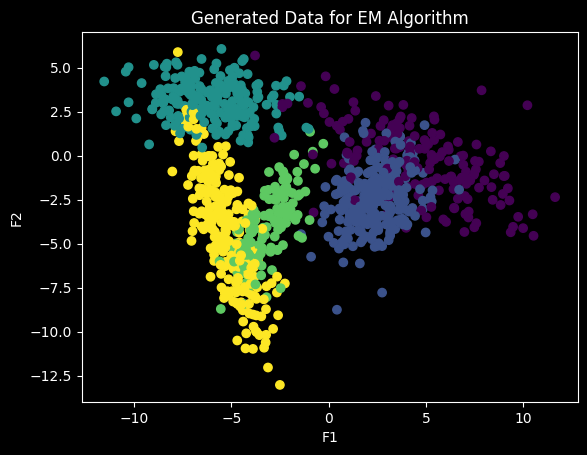

In [ ]:
def generate_data(N,K):
  mu,sg = [],[]
  for k in range(K):
    mu += [np.random.randn(2)*5]
    ss = np.random.randn(2,2)
    sg += [ss.T@ss + np.eye(2)/2]

  pi = np.random.rand(K)
  pi = pi/sum(pi)
  X,Z = [],[]
  for i in range(N):
    k = np.random.choice(np.arange(K),p=pi)
    X += [multivariate_normal.rvs(mu[k],sg[k])]
    Z += [k]
  X = np.row_stack(X)
  return X,Z,np.vstack(mu),sg,pi

X,Z_,mu_,sg_,pi_ = generate_data(1000,5)

plt.style.use('dark_background')
plt.scatter(X[:, 0], X[:, 1], c=Z_, cmap='viridis')
plt.title("Generated Data for EM Algorithm")
plt.xlabel("F1")
plt.ylabel("F2")
plt.show()


**1. feladat.** Implementáld a fenti algoritmust! Törekedj az egyszerűségre, mátrix-vektor műveletek használatára! (A feladat kb. 15 sorból megoldható.) A normális eloszlásnál érdemes a `scipy` megfelelő függvényét használni, azaz pl.

$$\mathcal{N}(\mathbf{x} | \mu_k, \Sigma_k)$$ valahogy így írható:

`multivariate_normal.pdf(X,mean=mu[k],cov=sg[k])`

In [ ]:
D = 2 # dimension of samples
K = 5 # number of clusters

pi = np.ones(K)/K                   # the initial uniform prior cluster probabilities
mu = np.random.randn(K,D)           # initial cluster centers (random)
sg = [np.eye(D) for k in range(K)]  # cluster covariances

# previous generation step
N = len(X)  # number of data points

# EM-algorithm (1000 iteration)
for iteration in range(1000):
    # E-step: calc responsibilities
    responsibilities = np.zeros((N, K))
    for k in range(K):
        responsibilities[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sg[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # M-step: update all other parameters
    Nk = responsibilities.sum(axis=0)  # sum of responsibilities for each cluster
    mu = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]  # update means

    for k in range(K):
        X_centered = X - mu[k]
        sg[k] = np.dot(responsibilities[:, k] * X_centered.T, X_centered) / Nk[k]  # update covariances

    pi = Nk / N  # update prior probabilities


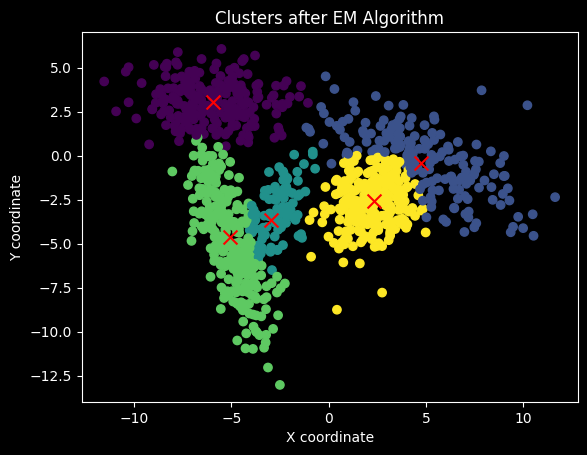

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=responsibilities.argmax(axis=1), cmap='viridis')
plt.scatter(mu[:, 0], mu[:, 1], s=100, c='red', marker='x')  # centers
plt.title("Clusters after EM Algorithm")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

**2. feladat.** Ábrázold a kiakakuló klasztereket! Az ábrán jelenjenek meg a pontok (klaszterenként különböző színekkel), valamint az illesztett komponensek szintvonalai (érdemes a naiv Bayes gyakorlatról kipuskázni az ábrázolást).

<ipython-input-15-603bc4ed0a56>:17: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


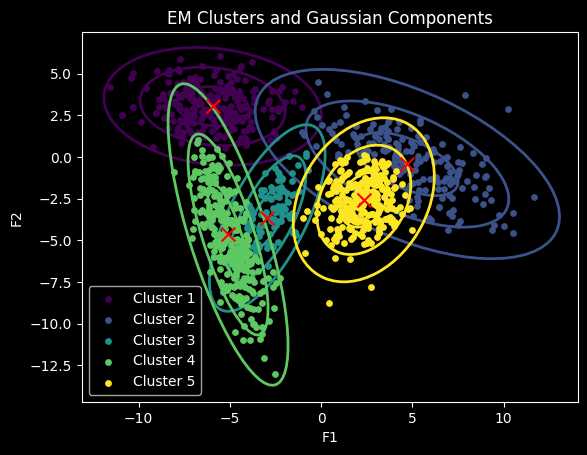

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()

    # convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # draw ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0, 1, K))

# plot each cluster
for k, color in enumerate(colors):
    members = responsibilities[:, k] > 0.5
    plt.scatter(X[members, 0], X[members, 1], s=15, color=color, label=f'Cluster {k+1}')

    # plot an ellipse to show the Gaussian component
    draw_ellipse(mu[k], sg[k], ax=ax, edgecolor=color, facecolor='none', linewidth=2)

plt.scatter(mu[:, 0], mu[:, 1], s=100, c='red', marker='x')  # cluster centers
plt.title("EM Clusters and Gaussian Components")
plt.xlabel("F1")
plt.ylabel("F2")
plt.legend()
plt.show()


**3. feladat.** Értékeld ki a megoldást a következők alapján:

- Prediktált és valódi klaszterezés együttjárása (`sklearn.metrics.adjusted_rand_score`)
- Klaszterközéppontok eltérése a valódi klaszterközéppontoktól (plot)

A kiértékelést végezd el több véletlenszerűen generált adathalmazon is. Mit tapasztalsz?

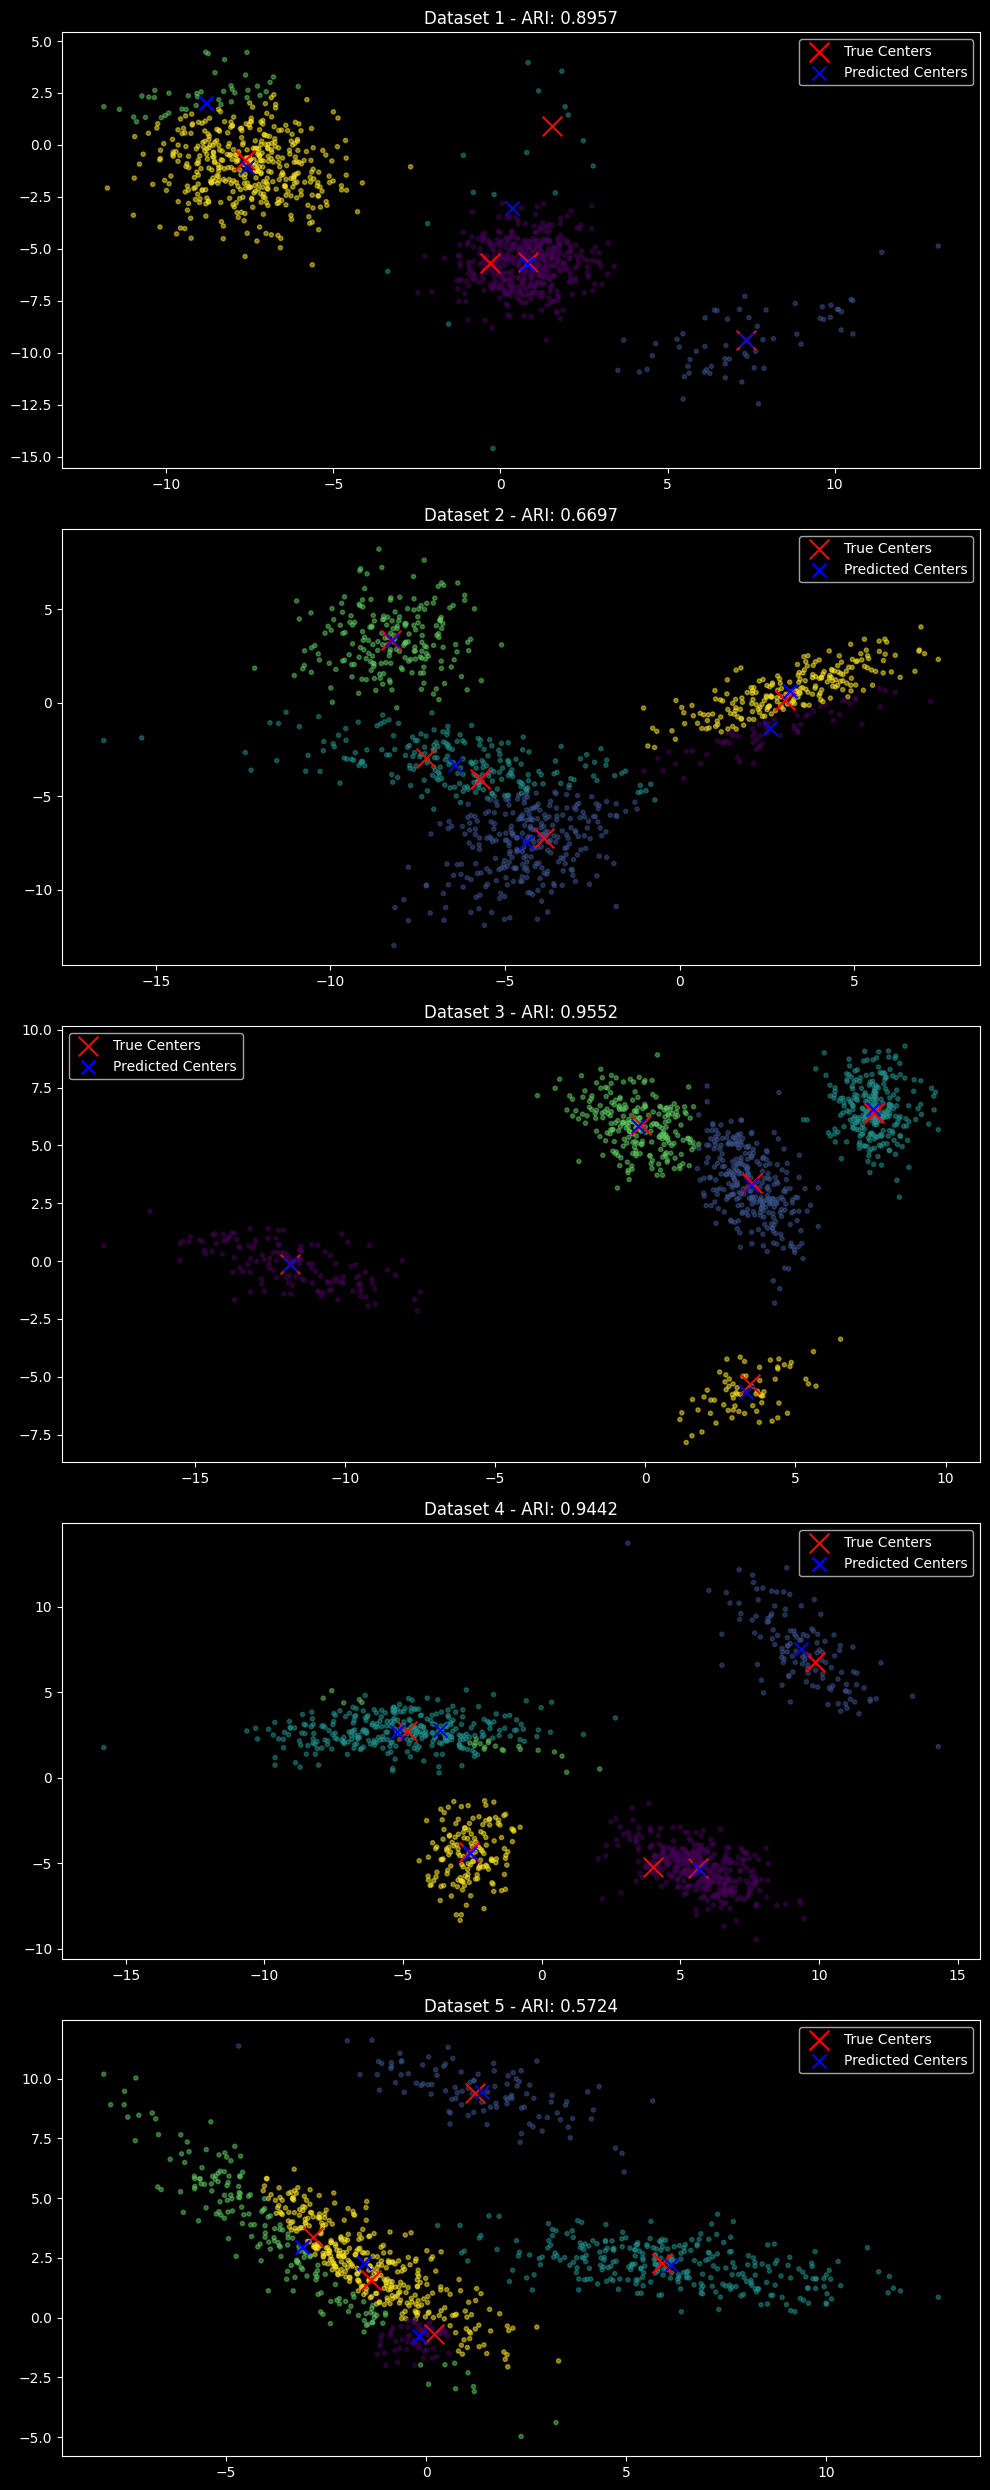

0.8074115546629699

In [ ]:
from sklearn.metrics import adjusted_rand_score

# already implemented above
def run_em_algorithm(X, K=5, D=2, max_iter=1000):
    pi = np.ones(K) / K
    mu = np.random.randn(K, D)
    sg = [np.eye(D) for _ in range(K)]

    for _ in range(max_iter):
        # E-step
        responsibilities = np.zeros((len(X), K))
        for k in range(K):
            responsibilities[:, k] = pi[k] * multivariate_normal.pdf(X, mean=mu[k], cov=sg[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step
        Nk = responsibilities.sum(axis=0)
        mu = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        for k in range(K):
            X_centered = X - mu[k]
            sg[k] = np.dot(responsibilities[:, k] * X_centered.T, X_centered) / Nk[k]
        pi = Nk / len(X)

    predicted_labels = np.argmax(responsibilities, axis=1)
    return mu, predicted_labels

# generate several datasets and evaluate
num_datasets = 5
ari_scores = []
fig, axs = plt.subplots(num_datasets, 1, figsize=(10, num_datasets * 5))

for i in range(num_datasets):
    X, true_labels, true_mu, _, _ = generate_data(1000, 5)
    predicted_mu, predicted_labels = run_em_algorithm(X)
    ari_score = adjusted_rand_score(true_labels, predicted_labels)
    ari_scores.append(ari_score)

    axs[i].scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5, marker='.')
    axs[i].scatter(true_mu[:, 0], true_mu[:, 1], s=200, marker='x', c='red', label='True Centers')
    axs[i].scatter(predicted_mu[:, 0], predicted_mu[:, 1], s=100, marker='x', c='blue', label='Predicted Centers')
    axs[i].set_title(f'Dataset {i+1} - ARI: {ari_score:.4f}')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# average ARI score
print(np.mean(ari_scores))


0.8074115546629699


# Változó eredmények magyarázata

- Ha a kezdeti értékek távol vannak az igazi paraméterektől, akkor az algoritmus beragadhat egy lokális minimumba.
- Ha az egyes klaszterekben lévő pontok "összefolynak" akkor is történhetnek nehézségek a megkülönböztetés során.
- Lehetséges hogy több iterációra lenne szükség az optimum eléréséhez.
- A kiugró adatpontok szintén befolyásolhatják a végeredményt.